# Importing Modules and Checking Directory 

In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
pd.__version__

'1.1.5'

In [3]:
os.getcwd()


'/Users/Livi/Projects/Black_mental_health/notebooks/Data_wrangling'

In [9]:
med = pd.read_csv('../../data/processed/final2013MEDICARE.csv', index_col=0)

MED is the df I will use to merge with Census and aggregate by zip code.
But I want a DF of providers as well, so I can compare doctors with mostly Black patients to doctors with mostly non-Black patients.

In [10]:
med['payment_per_service']=med.total_medicare_payment/med.number_of_services
med['percentage_rate'] = med.total_medicare_payment/ med.total_submitted_charges

In [11]:
df = med.drop(columns = ['npi','full_zip','country'])

In [12]:
df.columns

Index(['entity_code', 'state', 'provider_type',
       'medicare_participation_indicator', 'number_of_hcpcs',
       'number_of_services', 'total_beneficiaries', 'total_submitted_charges',
       'total_allowed_payment', 'total_medicare_payment',
       'avg_beneficiary_age', 'avg_hcc_risk_score', 'services_per_capita',
       'allowed_payment_per_capita', 'medicare_payment_per_capita',
       'submitted_charges_per_capita', 'region', 'subregion',
       'payment_per_service', 'percentage_rate'],
      dtype='object')

In [13]:
df = pd.get_dummies(df)

In [24]:
from math import trunc

df['class'] = df.percentage_rate.apply(lambda x: trunc(x*10))

In [27]:
df['class']

0         4
1         4
2         1
3         7
4         3
         ..
949950    5
949951    2
949952    5
949953    0
949954    4
Name: class, Length: 949955, dtype: int64

In [28]:
y = df['class']
X = df.drop(columns = ['class','percentage_rate'])

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [32]:
lr.fit(X_train, y_train)

/Users/Livi/opt/anaconda3/envs/springboard/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [33]:
ypred = lr.predict(X_test)

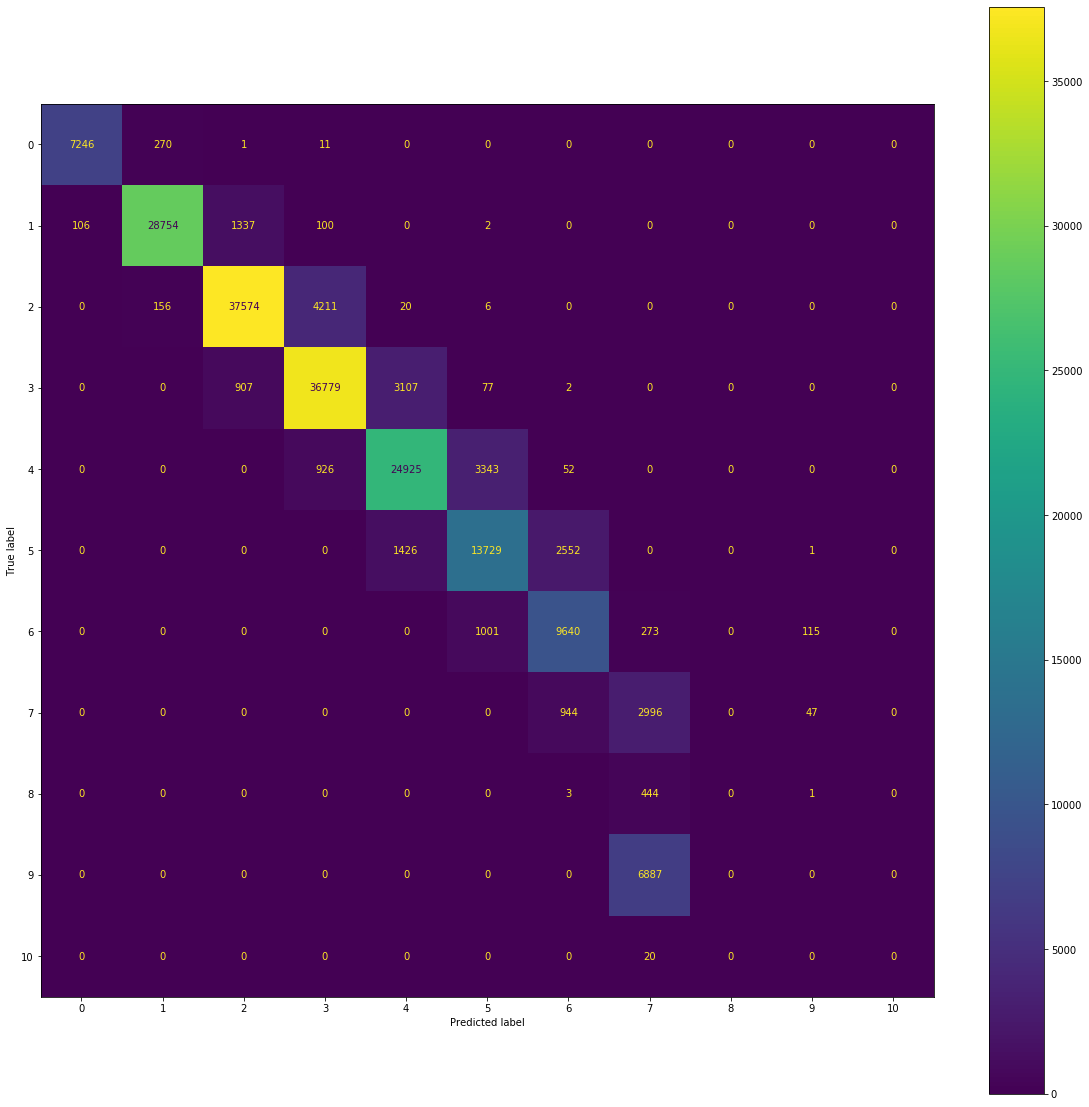

In [41]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(20,20))
plot_confusion_matrix(lr, X_test, y_test, ax=ax)

In [49]:
(y_test * X_test['total_submitted_charges']).sum() - (ypred /10 * X_test['total_submitted_charges']).sum()

134048276624.34598

In [52]:
pd.DataFrame((ypred/10 * X_test['total_submitted_charges'])).describe()

,total_submitted_charges
count,1.899910e+05
mean,7.803754e+04
std,5.235882e+05
min,0.000000e+00
25%,7.279882e+03
50%,2.546120e+04
75%,7.365802e+04
max,1.559942e+08


In [54]:
pd.DataFrame((y_test * X_test['total_submitted_charges'])).describe()

,0
count,1.899910e+05
mean,7.835882e+05
std,5.822459e+06
min,0.000000e+00
25%,7.189490e+04
50%,2.499180e+05
75%,7.301069e+05
max,2.005640e+09


In [71]:
pd.merge?

In [82]:
idx = X_test.sort_values('total_medicare_payment', ascending=False).head().index
X_test['ypred'] = ypred / 10

/Users/Livi/opt/anaconda3/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
X_test.columns

Index(['number_of_hcpcs', 'number_of_services', 'total_beneficiaries',
       'total_submitted_charges', 'total_allowed_payment',
       'total_medicare_payment', 'avg_beneficiary_age', 'avg_hcc_risk_score',
       'services_per_capita', 'allowed_payment_per_capita',
       ...
       'subregion_East South Central', 'subregion_Middle Atlantic',
       'subregion_Mountain', 'subregion_New England', 'subregion_Pacific',
       'subregion_South Atlantic', 'subregion_West North Central',
       'subregion_West South Central', 'class', 'ypred'],
      dtype='object', length=174)

In [87]:
X_test['new_payment_per_service'] = X_test.total_submitted_charges * X_test.ypred / X_test.number_of_services

/Users/Livi/opt/anaconda3/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [95]:
idx = X_test.index
providers = med.loc[idx,'provider_type']
X_test['provider_type'] = providers

/Users/Livi/opt/anaconda3/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# I looked at this DF by ordering by Risk Score, by Comparing Actual Payment to Predicted Pay, and finally, by Ordering by Diff Rate - PredictedRate.
# Seems highest diffs for for Other Health Services: Mass Immunization and Public Health Welfare Agency.
# I wonder how the model will do if I take out Other Health Services.

In [112]:
pd.options.display.max_rows = 100
X_test['diff'] = X_test.percentage_rate - X_test.ypred
X_test[['provider_type','total_medicare_payment','number_of_services','payment_per_service','new_payment_per_service', 'percentage_rate','ypred', 'diff','avg_hcc_risk_score']].sort_values('diff', ascending=False).head(100)

/Users/Livi/opt/anaconda3/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,provider_type,total_medicare_payment,number_of_services,payment_per_service,new_payment_per_service,percentage_rate,ypred,diff,avg_hcc_risk_score
743908,Mass Immunization Roster Biller,570.88,24,23.786667,16.650667,1.000000,0.7,0.300000,1.1957
267494,Mass Immunization Roster Biller,875.00,70,12.500000,8.750000,1.000000,0.7,0.300000,1.1155
617933,Mass Immunization Roster Biller,274.90,22,12.495455,8.746818,1.000000,0.7,0.300000,0.8611
858520,Public Health Welfare Agency,706.40,40,17.660000,12.362000,1.000000,0.7,0.300000,0.7910
9863,Multispecialty Clinic/Group Practice,706.00,353,2.000000,1.400000,1.000000,0.7,0.300000,1.6428
759809,Multispecialty Clinic/Group Practice,273.00,39,7.000000,4.900000,1.000000,0.7,0.300000,1.6747
861036,Public Health Welfare Agency,600.44,34,17.660000,12.362000,1.000000,0.7,0.300000,1.0502
93095,Mass Immunization Roster Biller,731.75,30,24.391667,17.074167,1.000000,0.7,0.300000,0.7364
856772,Public Health Welfare Agency,459.16,26,17.660000,12.362000,1.000000,0.7,0.300000,0.9660
924420,Mass Immunization Roster Biller,510.74,24,21.280833,14.896583,1.000000,0.7,0.300000,1.0056
